<font size="+3"><strong>Linear Regression with Time Series Data</strong></font>

## Temperature of Austin, Texas

Exploring the time series data from https://www.ncei.noaa.gov/ for highest temperature in Austin, Texas. This also create linear model to predict temperature readings.

In [10]:
!pip install pymongo


In [11]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import pytz
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
warnings.simplefilter(action="ignore", category=FutureWarning)
from datetime import datetime
import pandas as pd

# Prepare Data

In [12]:
def wrangle(path):
  # Read the csv file
  df = pd.read_csv(path)

  # Drop the NaN values
  df = df.dropna()

  # We only need max Temp(TMAX), drop all other columns
  df = df.drop(["STATION", "TMIN", "TOBS", "WESD", "WESF"], axis=1)

  # Convert date into timestamp and set as index
  df['DATE'] = pd.to_datetime(df['DATE'].str.strip(), format='%Y/%m/%d')
  df.set_index('DATE', inplace=True)

  # Add lag features
  df["TMAX.L1"] = df["TMAX"].shift(1)
  df.dropna(inplace=True)
  return df


In [15]:
!cd Austin_Temp_Linear_Regression/

In [17]:
df = wrangle("./Austin_Temp_Linear_Regression/3391285.csv")
print(df.info())
df.head()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5261 entries, 2008-12-18 to 2023-07-08
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TMAX     5261 non-null   float64
 1   TMAX.L1  5261 non-null   float64
dtypes: float64(2)
memory usage: 123.3 KB
None


,TMAX,TMAX.L1
DATE,,
2008-12-18,53.0,39.0
2008-12-19,66.0,53.0
2008-12-20,74.0,66.0
2008-12-21,78.0,74.0
2008-12-22,42.0,78.0


## Explore data

<Axes: title={'center': 'Distribution of Max temperature in Austin'}>

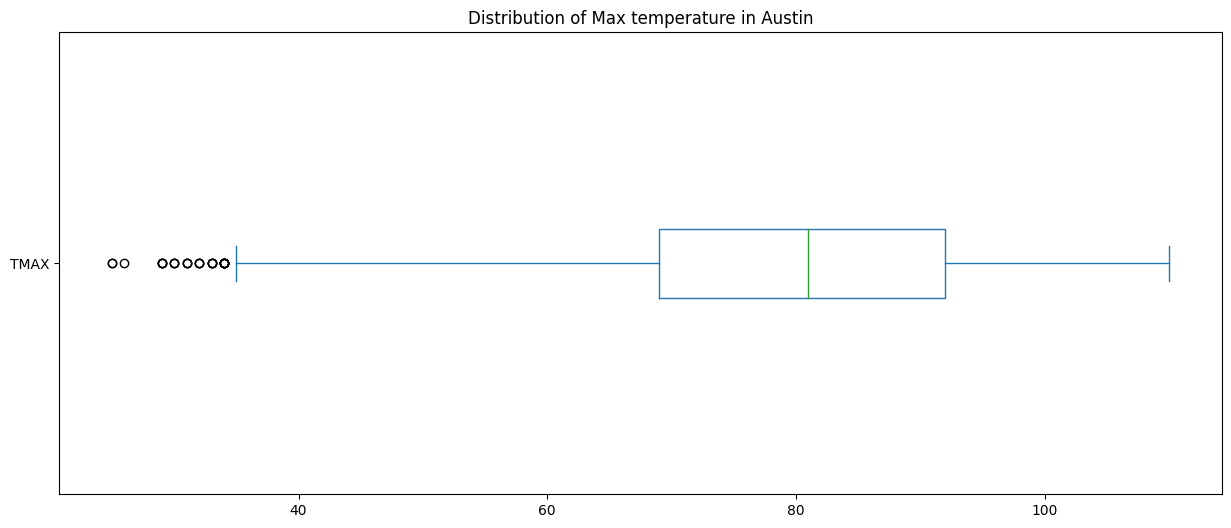

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))
df["TMAX"].plot(kind="box", vert=False, title="Distribution of Max temperature in Austin", ax=ax)

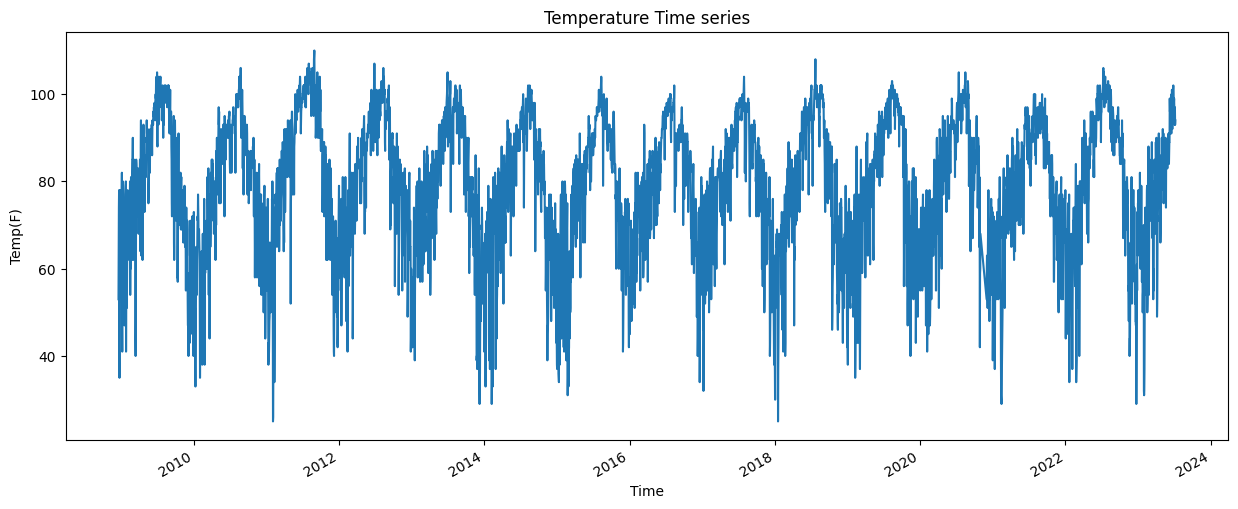

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))
df["TMAX"].plot(xlabel="Time", ylabel="Temp(F)", title="Temperature Time series", ax=ax);

quartly Rolling Average

In [20]:
df["TMAX"].rolling(30).mean()

DATE
2008-12-18          NaN
2008-12-19          NaN
2008-12-20          NaN
2008-12-21          NaN
2008-12-22          NaN
                ...    
2023-07-03    95.166667
2023-07-05    95.300000
2023-07-06    95.566667
2023-07-07    95.633333
2023-07-08    95.966667
Name: TMAX, Length: 5261, dtype: float64

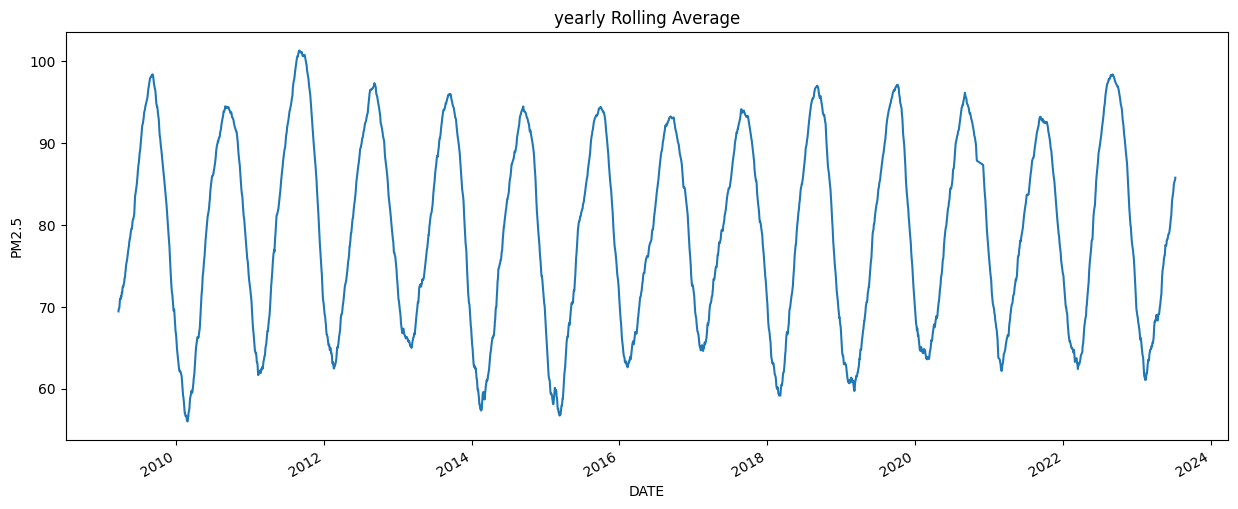

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))
df['TMAX'].rolling(30*3).mean().plot(ax=ax,x='DATE', y='TMAX',ylabel="PM2.5", title="yearly Rolling Average");

### Createw a correlation matrix for df

In [22]:
df.corr()

,TMAX,TMAX.L1
TMAX,1.000000,0.875281
TMAX.L1,0.875281,1.000000


Text(0.5, 1.0, 'TMAX correlation')

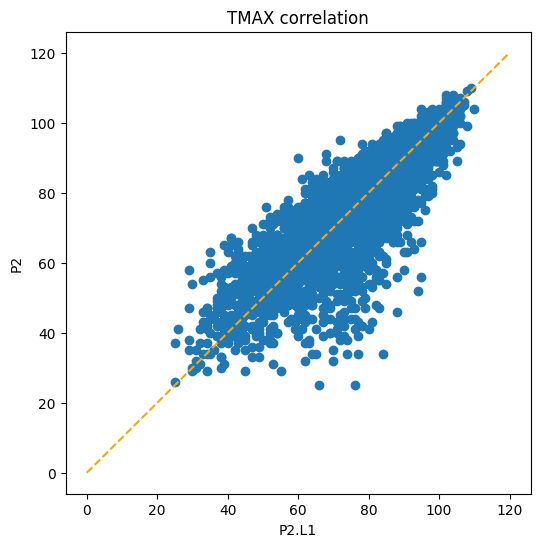

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=df["TMAX.L1"], y=df["TMAX"])
ax.plot([0, 120], [0, 120], linestyle="--", color="orange")
plt.xlabel("P2.L1")
plt.ylabel("P2")
plt.title("TMAX correlation")


## Building the model

In [24]:
target = "TMAX"
y = df[target]
X = df.drop(columns=target)
X.head()

,TMAX.L1
DATE,
2008-12-18,39.0
2008-12-19,53.0
2008-12-20,66.0
2008-12-21,74.0
2008-12-22,78.0


In [25]:
cutoff = int(len(X) * 0.8)


X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

#### Building baseline

In [26]:
y_pred_baseline = [y_train.mean()] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 79.03
Baseline MAE: 12.81


Iterate

In [27]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [28]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 5.33
Test MAE: 5.06


## Communicate Results

In [29]:
intercept = model.intercept_.round(2)

coefficient = model.coef_.round(2)[0]

print(f"TMAX = {intercept} + ({coefficient} * TMAX.L1)")

TMAX = 10.01 + (0.87 * TMAX.L1)


In [30]:
df_pred_test = pd.DataFrame(
    {
        "y_test": y_test,
        "y_pred": model.predict(X_test)
    }

)
df_pred_test.head()

,y_test,y_pred
DATE,,
2020-07-07,89.0,95.611569
2020-07-08,93.0,87.750513
2020-07-09,95.0,91.244315
2020-07-10,98.0,92.991217
2020-07-11,99.0,95.611569


In [31]:
fig = px.line(df_pred_test, labels={"value":"TMAX"})
fig.show()